In [1]:
import torch
torch.cuda.is_available()

/home/sinhaa2/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


False

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomNormal, RandomUniform
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm

tf.config.list_physical_devices()

2022-12-06 16:40:47.157338: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-12-06 16:40:47.157386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lj10
2022-12-06 16:40:47.157395: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lj10
2022-12-06 16:40:47.157470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.43.4
2022-12-06 16:40:47.157508: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.43.4
2022-12-06 16:40:47.157516: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.43.4


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Load Seurat processed counts and annotations

In [2]:
def filter_genes(counts):
    # get gene names in count matrix
    genes = counts.columns
    # get TF and RBP list
    temp1 = pd.read_csv('/data/leslie/sinhaa2/cellmem/data/db/cisbp-tf.csv')['Name']
    temp2 = pd.read_csv('/data/leslie/sinhaa2/cellmem/data/db/cisbp-rbp.csv')['Name']
    tfrbp = np.unique( np.concatenate((temp1,temp2)) )
    del temp1, temp2
    # get the positions of TF-RBPs in gene list of count matrix 
    idx = np.nonzero(np.in1d(genes, tfrbp))[0]
    # filter count matrix columns
    counts = counts.iloc[:, idx]
    return counts

In [4]:
import pandas as pd
datadir = '/data/leslie/sinhaa2/cellmem/data/seurat/'
modeldir = '/data/leslie/sinhaa2/cellmem/models/marrow/'

labels = np.array(pd.read_csv(datadir+'marrow_labels.csv')['x'])    # labels (#cell,)
ctypes = np.unique(labels)
counts = pd.read_csv(datadir+'marrow_5000.csv', index_col=0)             # counts (#cell, #genes)
# counts = filter_genes(counts)               # filter genes based on TF-RBP
M = counts.to_numpy()
counts.head()

,Elane,Mpo,Prss34,Mcpt8,Gzma,Igj,Prtn3,Igll1,Cd209a,Retnlg,...,1810063B07Rik,Map3k13,Uprt,Calm4,Gm8369,Ak3,4930431P03Rik,Relt,Tpi1,Xk
A22.D042044.3_9_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.230186,0.0,0.0,0.0,0.0,0.000000,0.0,2.299874,0.000000,0.000000
C5.D042044.3_9_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.755478,0.000000
D10.D042044.3_9_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,1.187216,0.0,0.000000,2.061091,0.000000
E13.D042044.3_9_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
F19.D042044.3_9_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.091402


## UMAP visualization

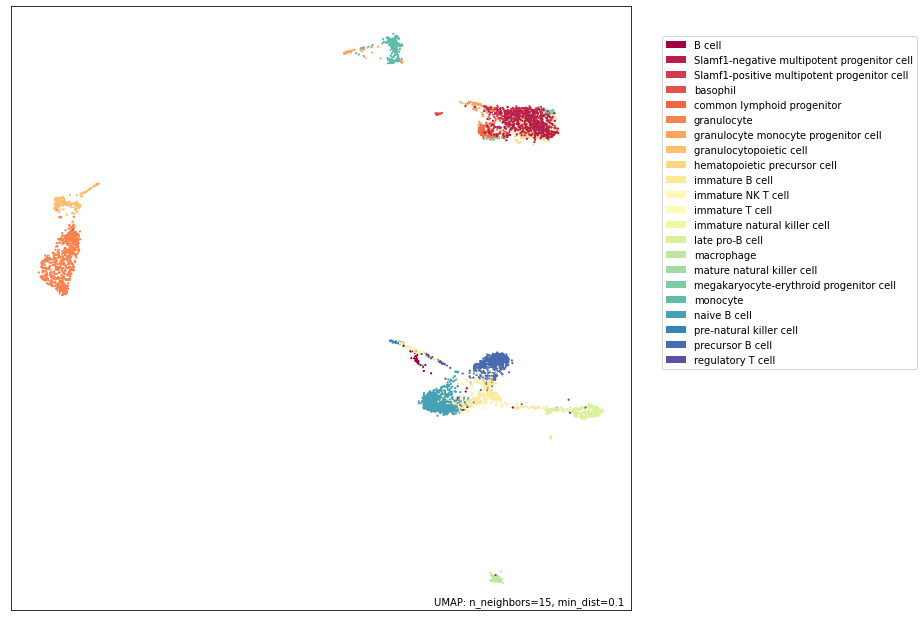

In [110]:
import umap
import umap.plot

# mapper = umap.UMAP().fit(M)
ax = umap.plot.points(mapper, labels=labels)#, width=400, height=400)
legend = ax.get_legend()
ax.legend(legend.legendHandles, (x.get_text() for x in legend.get_texts()), loc=(1.05,0.4))
plt.show()

## Cellular Memories training

In [15]:
np.amax(M)

7.76900937883533

In [16]:
N2 = len(np.unique(labels))       # memories
Ns, N1 = M.shape
MS = int(0.08*N1)              # mask size

mu = 0.01           # parameters for weights initialization
sigma = 0.01
N_steps = 3         # number of HN iterations

beta = 0.05           # initial inv. temperature parameter setting
R0 = np.amax(M)              # initial radius setting

batch_size = 32
eps = 0.005          # ADAM lr
N_ep = 200        # epochs

alpha = .5            # initial alpha setting (dt/tau)

In [17]:
class MHN_WITH_1_HIDDEN_LAYER(tf.keras.layers.Layer):
    def __init__(self, N1=N1, N2=N2, **kwargs):
        super().__init__(**kwargs)
        self.N1 = N1
        self.N2 = N2        

    def build(self, input_shape):
        self.kernel = self.add_weight(
            "kernel",
            shape=[self.N1, self.N2],
            initializer=RandomNormal(mean=mu, stddev=sigma, seed=None)
        )
        self.beta = self.add_weight(
            "beta",
            shape=[1, 1],
            initializer=RandomNormal(mean=beta, stddev=0.01, seed=None)
        )
        self.R = self.add_weight(
            "R",
            shape=[1, 1],
            initializer=RandomNormal(mean=R0, stddev=0.01, seed=None)
        )
        self.alpha = self.add_weight(
            "alpha",
            shape=[1, 1],
            initializer=RandomNormal(mean=alpha, stddev=0.01, seed=None)
        )
        
        super().build(input_shape)

    def call(self, v, mask):   # one iteration of visible unit update
        # Eq. 15 in LAM paper
        nc = tf.sqrt(tf.reduce_sum(tf.square(self.kernel), axis=[0]))
        Mem = self.kernel/nc*self.R       # Memories
        
        h = tf.matmul(v,Mem)              # hidden units
        SM = tf.nn.softmax(self.beta*h)
        # update visible units using finite differences
        U = tf.matmul(SM, tf.transpose(Mem)) - v    # residual
        return [v + self.alpha*U*mask, SM]

In [104]:
tf.keras.backend.clear_session()

input_mask = Input(shape=[N1])
input1 = Input(shape=[N1])
MHN_cell = MHN_WITH_1_HIDDEN_LAYER(N1, N2)

# define model
x, SM = MHN_cell(input1, input_mask)
for _ in range(N_steps-1):
    x, SM = MHN_cell(x, input_mask)

model = Model(inputs=[input1, input_mask], outputs=x)
weights = np.load(modeldir+'weights_5000.npy', allow_pickle=True)
model.set_weights(weights)
mem = weights[0]
mem = ( mem/np.linalg.norm(mem, axis=0)*weights[2][0][0] ).T

optimizer = Adam(learning_rate=eps)

train_dataset = tf.data.Dataset.from_tensor_slices((M, M))
train_dataset = train_dataset.shuffle(Ns).batch(batch_size)

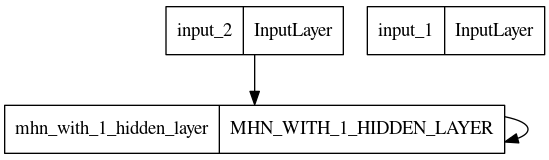

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5000)]       0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 5000)]       0           []                               
                                                                                                  
 mhn_with_1_hidden_layer (MHN_W  [(None, 5000),      110003      ['input_2[0][0]',                
 ITH_1_HIDDEN_LAYER)             (None, 22)]                      'input_1[0][0]',                
                                                                  'mhn_with_1_hidden_layer[0][0]',
                                                                  'input_1[0][0]',            

In [21]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = ' - '.join(["{}: {:.4f}".format('loss', m) for m in [loss] + (metrics or [])])
    end = '' if iteration < total else '\n'
    print('\r{}/{} - '.format(iteration, total) + metrics, end=end)

def mean_squared_error(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true-y_pred))*N1/MS
    return loss

def draw_weights(fig, ax, mem, mapper=mapper):
    mem = mapper.transform(mem)
    
    if len(ax.collections)==2:         # if a scatter has been made in previous epochs
        ax.collections.pop(1)  # clear it
    ax.scatter(mem[:,0],mem[:,1], c='m', s=40, marker='x')      # new scatter of updated memory vectors
    fig.canvas.draw()

<IPython.core.display.Javascript object>


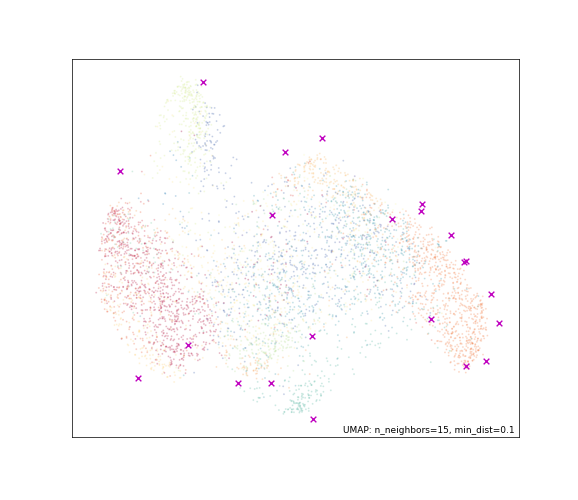

Epoch 1/200
5056/5037 - loss: 0.3739
Current beta is:  0.052003898 , current R is:  5.1639075 , current alpha is:  0.6144959
Epoch 2/200
5056/5037 - loss: 0.3243
Current beta is:  0.05231314 , current R is:  5.268137 , current alpha is:  0.6884611
Epoch 3/200
5056/5037 - loss: 0.3516
Current beta is:  0.052621428 , current R is:  5.3681126 , current alpha is:  0.7446006
Epoch 4/200
5056/5037 - loss: 0.3536
Current beta is:  0.053131342 , current R is:  5.4645863 , current alpha is:  0.78795964
Epoch 5/200
5056/5037 - loss: 0.3115
Current beta is:  0.054156773 , current R is:  5.558559 , current alpha is:  0.8221579
Epoch 6/200
5056/5037 - loss: 0.3023
Current beta is:  0.0561964 , current R is:  5.6485157 , current alpha is:  0.8489081
Epoch 7/200
5056/5037 - loss: 0.3285
Current beta is:  0.061289508 , current R is:  5.7348313 , current alpha is:  0.8700946
Epoch 8/200
5056/5037 - loss: 0.3345
Current beta is:  0.081124954 , current R is:  5.817673 , current alpha is:  0.88710177
Epoc

5056/5037 - loss: 0.3018
Current beta is:  0.09516313 , current R is:  8.869811 , current alpha is:  1.8621267
Epoch 68/200
5056/5037 - loss: 0.3029
Current beta is:  0.09084761 , current R is:  8.875459 , current alpha is:  1.8644178
Epoch 69/200
5056/5037 - loss: 0.3271
Current beta is:  0.09359537 , current R is:  8.88557 , current alpha is:  1.8697145
Epoch 70/200
5056/5037 - loss: 0.2992
Current beta is:  0.09095985 , current R is:  8.892477 , current alpha is:  1.8717104
Epoch 71/200
5056/5037 - loss: 0.2863
Current beta is:  0.088377774 , current R is:  8.899095 , current alpha is:  1.875864
Epoch 72/200
5056/5037 - loss: 0.3237
Current beta is:  0.086341605 , current R is:  8.906226 , current alpha is:  1.8794746
Epoch 73/200
5056/5037 - loss: 0.2415
Current beta is:  0.0859131 , current R is:  8.918734 , current alpha is:  1.8883234
Epoch 74/200
5056/5037 - loss: 0.2722
Current beta is:  0.08180886 , current R is:  8.926296 , current alpha is:  1.8927491
Epoch 75/200
5056/5037

5056/5037 - loss: 0.2768
Current beta is:  0.05873013 , current R is:  9.322124 , current alpha is:  1.9496899
Epoch 134/200
5056/5037 - loss: 0.3225
Current beta is:  0.05809546 , current R is:  9.327504 , current alpha is:  1.9487197
Epoch 135/200
5056/5037 - loss: 0.2791
Current beta is:  0.05848099 , current R is:  9.333076 , current alpha is:  1.9485737
Epoch 136/200
5056/5037 - loss: 0.2781
Current beta is:  0.05947932 , current R is:  9.339101 , current alpha is:  1.9477416
Epoch 137/200
5056/5037 - loss: 0.3068
Current beta is:  0.060112827 , current R is:  9.349736 , current alpha is:  1.9536176
Epoch 138/200
5056/5037 - loss: 0.3075
Current beta is:  0.05936007 , current R is:  9.351891 , current alpha is:  1.94892
Epoch 139/200
5056/5037 - loss: 0.2882
Current beta is:  0.05970811 , current R is:  9.356613 , current alpha is:  1.94788
Epoch 140/200
5056/5037 - loss: 0.2845
Current beta is:  0.058693007 , current R is:  9.36373 , current alpha is:  1.950136
Epoch 141/200
5056

5056/5037 - loss: 0.3042
Current beta is:  0.05263302 , current R is:  9.689872 , current alpha is:  1.9610376
Epoch 200/200
5056/5037 - loss: 0.2746
Current beta is:  0.050992765 , current R is:  9.695922 , current alpha is:  1.9646294


In [142]:
%matplotlib inline
%matplotlib notebook
ax = umap.plot.points(mapper, labels=labels, alpha=0.2, show_legend=False)
fig = plt.gcf()
fig.set_size_inches(9, 9)
fig.canvas.draw()

N_ep=200
new_lr = eps
for epoch in range(1, N_ep+1):
    print(f'Epoch {epoch}/{N_ep}')
#     if epoch%20==0:
#         new_lr = new_lr/5
#         optimizer.lr.assign(new_lr)
    for step, (x_train, y_train) in enumerate(train_dataset):
        # masking training data
        x_train = tf.cast(x_train,dtype=tf.float32)
        y_train = tf.cast(y_train,dtype=tf.float32)
        mask = np.zeros_like(x_train)
        for i in range(len(x_train)):
            idx = np.random.choice(N1, MS, replace=False)
            mask[i,idx] = 1.
        mask = tf.convert_to_tensor(mask, dtype=tf.float32)
        x_train_masked = x_train*tf.cast(1.0-mask, dtype=tf.float32)
        
        
        # update weights
        with tf.GradientTape() as tape:
            y_pred = model([x_train_masked, mask])
            loss = mean_squared_error(y_train, y_pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.learning_rate.assign(eps)
        optimizer.apply_gradients(zip(gradients[:1], model.trainable_variables[:1]))
        
        optimizer.learning_rate.assign(eps/10)
        optimizer.apply_gradients(zip(gradients[1:], model.trainable_variables[1:]))

        for _ in range(1,len(model.trainable_variables)):
            model.trainable_variables[_].assign(tf.clip_by_value(model.trainable_variables[_], 0.01, 100))
        
        #print_status_bar
        print_status_bar((step+1)*batch_size, Ns, tf.sqrt(loss))
        
        current_beta = model.layers[2].get_weights()[1][0][0]
        current_R = model.layers[2].get_weights()[2][0][0]
        current_alpha = model.layers[2].get_weights()[3][0][0]
        mem = model.layers[2].get_weights()[0]
        mem = ( mem/np.linalg.norm(mem, axis=0)*current_R ).T

    # plot weights
    print('Current beta is: ', current_beta, ', current R is: ', current_R, ', current alpha is: ', current_alpha)
    if epoch%5==0:
        draw_weights(fig, ax, mem)

## Testing stuff

## Visualizations

In [106]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:
    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgb(self, val):
        return self.scalarMap.to_rgba(val)

colors = MplColorHelper('Spectral', 1, len(mem))

In [107]:
np.unique(labels, return_counts=True)#[1][c-1]

(array(['B cell', 'Slamf1-negative multipotent progenitor cell',
        'Slamf1-positive multipotent progenitor cell', 'basophil',
        'common lymphoid progenitor', 'granulocyte',
        'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
        'hematopoietic precursor cell', 'immature B cell',
        'immature NK T cell', 'immature T cell',
        'immature natural killer cell', 'late pro-B cell', 'macrophage',
        'mature natural killer cell',
        'megakaryocyte-erythroid progenitor cell', 'monocyte',
        'naive B cell', 'pre-natural killer cell', 'precursor B cell',
        'regulatory T cell'], dtype=object),
 array([ 44, 713, 134,  25, 156, 761, 134, 221, 265, 344,  37,  60,  36,
        306, 173,  49,  55, 266, 692,  22, 517,  27]))

(0.0, 50.0)

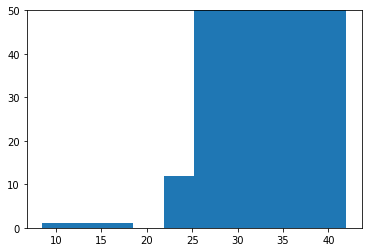

In [119]:
plt.hist(np.linalg.norm(M, axis=1))
plt.ylim(0,50)

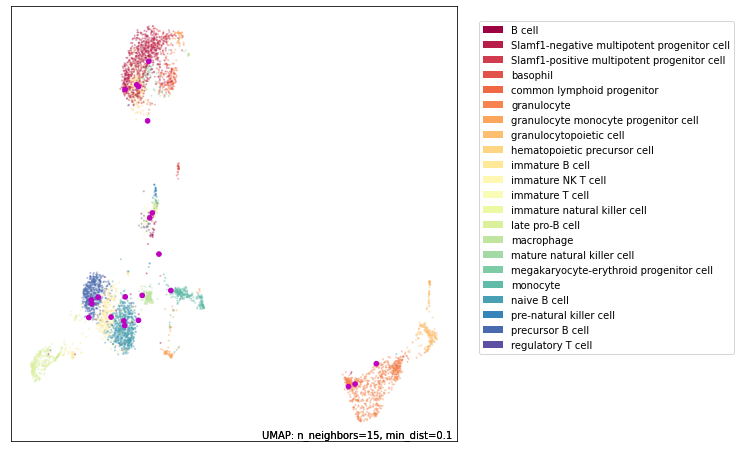

In [120]:
M_t = np.concatenate((M,mem), axis=0)
labels_t = np.concatenate((labels,len(mem)*['memories']))

mapper_t = umap.UMAP().fit(M_t)
## Code to plot UMAP colored by original labels
fig, ax = plt.subplots(figsize=(8,8))
ax = umap.plot.points(mapper_t, labels=labels_t, alpha=0.3, subset_points=[True]*len(labels)+[False]*len(mem), ax=ax)
legend = ax.get_legend()
umap.plot.points(mapper_t, labels=labels_t, alpha=1, color_key='m', subset_points=[False]*len(labels)+[True]*len(mem), ax=ax)
ax.legend(legend.legendHandles, (x.get_text() for x in legend.get_texts()), loc=(1.05,0.2))

## Code to subset out points of specific annotated cell types
# fig, ax = plt.subplots(figsize=(6,6))
# c = 12
# mask = np.full(len(labels_t), False)
# mask[np.where(labels_t==ctypes[c-1])[0]] = True
# # print(np.sum(mask))
# ax = umap.plot.points(mapper_t, labels=mask, alpha=1, color_key=['#DCDCDC', colors.get_rgb(c)] , subset_points=[True]*len(labels)+[False]*len(mem), ax=ax, show_legend=False)
# plt.text(-7.5,22,c)

plt.show()

In [64]:
print(np.max(M))
print(np.min(M))
print(np.max(mem))
print(np.min(mem))

7.76900937883533
0.0
8.996928
-3.6532054


## Energy computation

In [62]:
E = 0.5*np.sum(M**2, axis=1) - np.log( np.sum(np.exp(M @ mem.T, dtype=np.float128), axis=1) )       # energy level for each cell
print(np.max(E))
print(np.min(E))

270.874440829467801
-378.10331121227631002


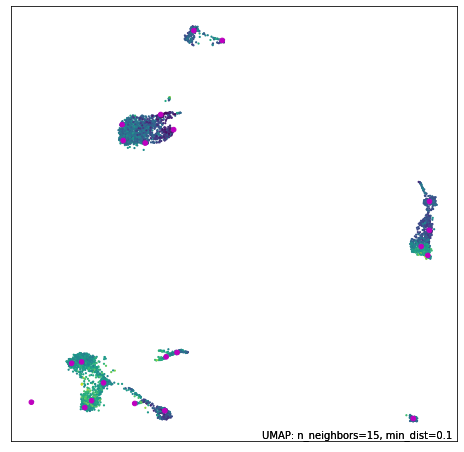

In [63]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(8,8))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size="7%", pad=0.2,)

E_t = np.concatenate((E,np.zeros(len(mem))))
umap.plot.points(mapper_t, values=E_t, cmap='viridis', alpha=1, subset_points=[True]*len(labels)+[False]*len(mem), ax=ax)
umap.plot.points(mapper_t, labels=labels_t, alpha=1, color_key='m', subset_points=[False]*len(labels)+[True]*len(mem), ax=ax, show_legend=False)

# plt.colorbar(a, cax=cax)
plt.show()

## Expression value histograms

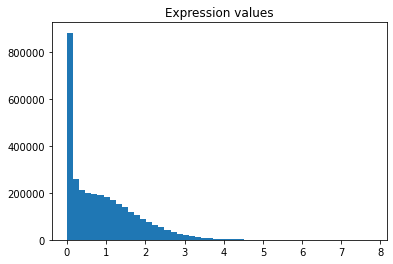

In [27]:
plt.figure()
temp = M.reshape(-1)
temp = temp[np.nonzero(temp)]
plt.hist(temp, bins=50)
plt.title('Expression values')
plt.show()

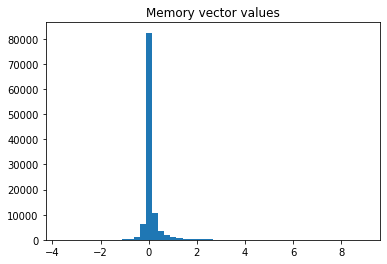

In [28]:
plt.figure()
plt.hist(mem.reshape(-1), bins=50)
plt.title('Memory vector values')
plt.show()

## Recovery Trajectory

In [29]:
# pick out sample points
n_test = 20
M_test = M[ np.random.choice(np.arange(len(M)), n_test, replace=False), :]
temp = [model.layers[2].get_weights()[0], model.layers[2].get_weights()[1][0][0], model.layers[2].get_weights()[2][0][0], model.layers[2].get_weights()[3][0][0]]

# iterate through model
traj = [tf.cast(M_test, dtype=tf.float32)]

iters = 10
for i in range(iters):
    h = tf.matmul(traj[-1], temp[0])              # hidden units
    SM = tf.nn.softmax(temp[1]*h)
    traj.append( tf.matmul(SM, tf.transpose(temp[0])) )

# convert to 3D array
traj = np.stack(traj)
# # embed in UMAP
traj_umap = np.zeros((traj.shape[0], traj.shape[1],2))
for i in tqdm(range(iters+1)):
    traj_umap[i] = mapper_t.transform(traj[i])

traj = traj.transpose(1,0,2)
traj_umap = traj_umap.transpose(1,0,2)

2022-10-26 09:19:39.811649: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


  0%|          | 0/11 [00:00<?, ?it/s]

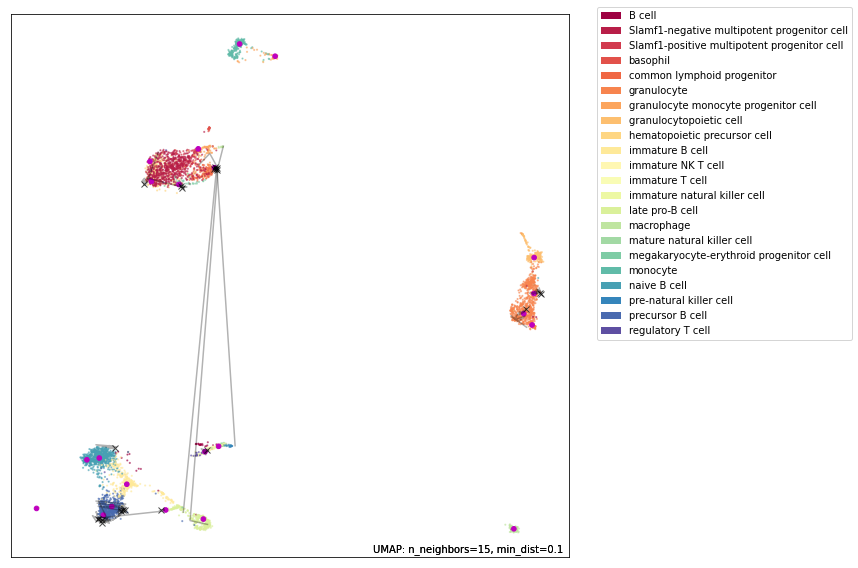

In [30]:
# plot the trajectories
fig, ax = plt.subplots(figsize=(10,10))

ax = umap.plot.points(mapper_t, labels=labels_t, alpha=0.5, subset_points=[True]*len(labels)+[False]*len(mem), ax=ax)
legend = ax.get_legend()
umap.plot.points(mapper_t, labels=labels_t, alpha=1, color_key='m', subset_points=[False]*len(labels)+[True]*len(mem), ax=ax)
ax.legend(legend.legendHandles, (x.get_text() for x in legend.get_texts()), loc=(1.05,0.4))

for i in range(len(traj_umap)):
    ax.plot(traj_umap[i,:,0], traj_umap[i,:,1], c='k', alpha=0.3)
    ax.plot(traj_umap[i,-1,0], traj_umap[i,-1,1], c='k', marker='x', alpha=0.7)

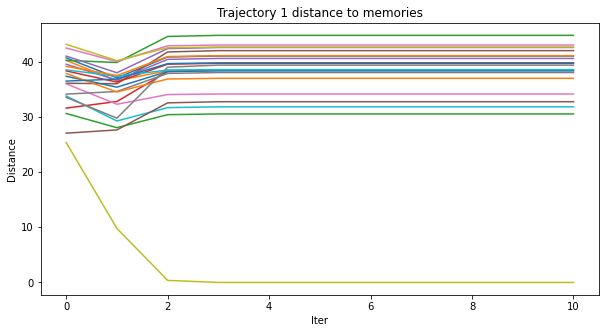

In [142]:
# distance to memories
idx = np.random.choice(n_test)
temp = mapper_t.transform(mem)
plt.figure(figsize=(10,5))
for i in range(len(mem)):
    plt.plot(np.linalg.norm(traj[idx,] - mem[i], axis=1))
plt.title(f'Trajectory {idx} distance to memories')
plt.xlabel('Iter')
plt.ylabel('Distance')
plt.show()

## Partition UMAP into memory basins

In [220]:
# Naive idea: Run trajectory from each starting point in set and assign it to one of the memory basins
iters = 20
temp = [model.layers[2].get_weights()[0], model.layers[2].get_weights()[1][0][0], model.layers[2].get_weights()[2][0][0], model.layers[2].get_weights()[3][0][0]]

dest = tf.cast(M, dtype=tf.float32)

for i in range(iters):
    h = tf.matmul(dest, temp[0])              # hidden units
    SM = tf.nn.softmax(temp[1]*h)
    dest = tf.matmul(SM, tf.transpose(temp[0]))

dest = dest.numpy()

dists = np.zeros((len(M),len(mem)))
for i in range(len(mem)):
    dists[:,i] = np.linalg.norm(dest-mem[i], axis=1)

thresh = 1     # threshold for acceptance as converging to memory
# get memory basin labels based on minimum distance provided threshold is met
mem_labels = np.array( [x if y<thresh else 0 for x,y in zip(np.argmin(dists, axis=1)+1, np.amin(dists, axis=1))] )

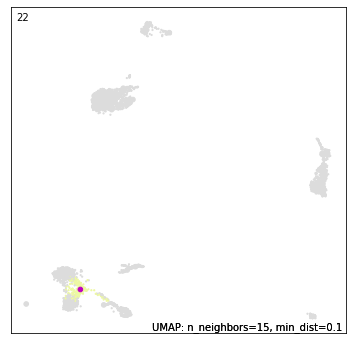

In [344]:
labels_m = np.concatenate((mem_labels,len(mem)*['memories']))
locs = [np.where(np.unique(labels_m)==str(c))[0] for c in range(1,len(mem)+1)]
fig, ax = plt.subplots(figsize=(6,6))

# Plot UMAP colored by memory basin clusters
idx = np.array([True]*len(labels)+[False]*len(mem))
idx[np.where(labels_m == '0')[0]] = False
idx_mem = [False]*len(labels)+[True]*len(mem)

# ax = umap.plot.points(mapper_t, labels=labels_m, alpha=0.6, subset_points=idx, ax=ax, show_legend=False)
# umap.plot.points(mapper_t, labels=labels_m, alpha=1, color_key='m', subset_points=idx_mem, ax=ax, show_legend=False)

# Code to subset out points of specific memory basin
c = 22
mask = np.full(len(labels_m), '0', dtype='<U2')
mask[np.where(labels_m==str(c))[0]] = str(c)
ax = umap.plot.points(mapper_t, labels=mask, alpha=1, color_key=['#DCDCDC', colors.get_rgb(locs[c-1])] , subset_points=idx, ax=ax, show_legend=False)
mask = np.full(len(labels_m), '0')
mask[len(labels)+c-1] = str(c)
umap.plot.points(mapper_t, labels=mask, alpha=1, color_key=['#DCDCDC', 'm'], subset_points=idx_mem, ax=ax, show_legend=False)
plt.text(-7.5,22,c)

plt.show()

## Save

In [152]:
import os
modeldir = '/data/leslie/sinhaa2/cellmem/models/marrow/'
if not os.path.exists(modeldir):
    os.mkdir(modeldir)
np.save(modeldir+'weights_5000.npy', model.layers[2].get_weights(), allow_pickle=True)

/home/sinhaa2/anaconda3/envs/tf/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [153]:
import pickle
with open(modeldir+'mapper_5000.pkl','wb') as f:
    pickle.dump([mapper, mapper_t], f)

## Load

In [6]:
import pickle
with open(modeldir+'mapper_5000.pkl','rb') as f:
    mapper, mapper_t = pickle.load(f)